In [ ]:
!pip install emcee corner
!pip install emcee
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import interp1d
import corner
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.0 MB/s eta 0:00:00


Running MCMC...


100%|██████████| 10000/10000 [00:33<00:00, 301.89it/s]


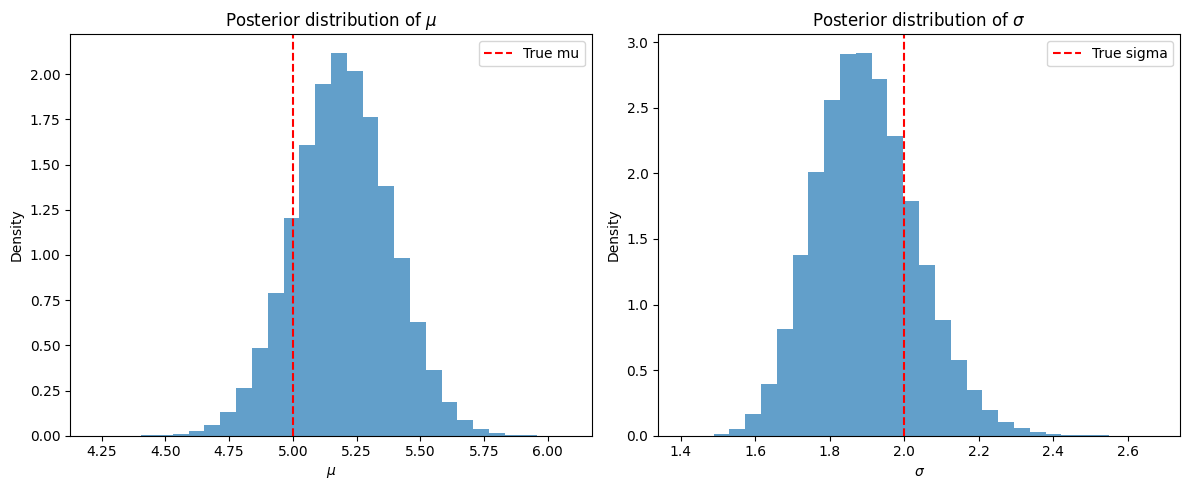

In [ ]:
# ----------------------------
# 1. Generate Synthetic Data
# ----------------------------
#np.random.seed(42)   # Pseudorandom Seed
true_mu = 5.0        # True mean
true_sigma = 2.0     # True standard deviation
N = 100              # Number of data points

# Generate data from a Gaussian distribution
data = np.random.normal(true_mu, true_sigma, N)

# Create some noise

noise_coefficient = 0.1
noise = noise_coefficient * np.random.normal(0, true_sigma, N)
data += noise

# ----------------------------
# 2. Define the Model
# ----------------------------

def log_likelihood(theta, data):
    """Log-likelihood for the Gaussian model.

    Parameters:
        theta : tuple
            A tuple containing the parameters (mu, log_sigma). We use log(sigma)
            to ensure that sigma > 0.
        data : array_like
            The observed data.

    Returns:
        float : The log-likelihood value.
    """
    mu, log_sigma = theta
    sigma = np.exp(log_sigma)  # ensure sigma > 0
    # The Gaussian log-likelihood for independent data points:
    return -0.5 * np.sum(((data - mu) / sigma)**2 + 2 * np.log(sigma) + np.log(2 * np.pi))

def log_prior(theta):
    """Log-prior for the parameters.

    We choose uniform (flat) priors on mu and log_sigma over a reasonable range.
    """
    mu, log_sigma = theta
    if -10.0 < mu < 10.0 and -5.0 < log_sigma < 5.0:
        return 0.0  # log(1) = 0 for a flat prior
    return -np.inf  # log(0) = -infinity outside the bounds

def log_probability(theta, data):
    """Combined log-prior and log-likelihood."""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

# ----------------------------
# 3. Set Up and Run MCMC with emcee
# ----------------------------
ndim = 2       # number of parameters: mu and log_sigma
nwalkers = 50  # number of MCMC walkers

# Initial guess for the parameters based on the data
initial_mu = np.mean(data)
initial_log_sigma = np.log(np.std(data))
initial = np.array([initial_mu, initial_log_sigma])

# Initialize the walkers in a tiny ball around the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data,))

# Run MCMC for 5000 steps (you can adjust the number of steps as needed)
print("Running MCMC...")
nsteps = 10000
sampler.run_mcmc(pos, nsteps, progress=True);

# Remove burn-in: assume the first 20% of samples are burn-in and flatten
burnin = int(nsteps * 0.2)
samples = sampler.get_chain(discard=burnin, flat=True)

# Convert log_sigma samples back to sigma
mu_samples = samples[:, 0]
sigma_samples = np.exp(samples[:, 1])

# ----------------------------
# 4. Plot the Results
# ----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, density=True, alpha=0.7)
plt.axvline(true_mu, color='red', linestyle='--', label='True mu')
plt.xlabel(r"$\mu$")
plt.ylabel("Density")
plt.title("Posterior distribution of $\mu$")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.7)
plt.axvline(true_sigma, color='red', linestyle='--', label='True sigma')
plt.xlabel(r"$\sigma$")
plt.ylabel("Density")
plt.title("Posterior distribution of $\sigma$")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ----------------------------
# 5. Extract the Most Likely Value (MAP) Using KDE
# ----------------------------

# For mu:
density_mu = gaussian_kde(mu_samples)
x_mu = np.linspace(mu_samples.min(), mu_samples.max(), 1000)
density_vals_mu = density_mu(x_mu)
map_mu = x_mu[np.argmax(density_vals_mu)]

# For sigma:
density_sigma = gaussian_kde(sigma_samples)
x_sigma = np.linspace(sigma_samples.min(), sigma_samples.max(), 1000)
density_vals_sigma = density_sigma(x_sigma)
map_sigma = x_sigma[np.argmax(density_vals_sigma)]

# Calculate the standard deviation for mu
std_mu = np.std(mu_samples)

# Calculate the standard deviation for sigma
std_sigma = np.std(sigma_samples)

print("MAP estimate for mu: {:.2f} +- {:.2f}".format(map_mu, std_mu))
print("MAP estimate for sigma: {:.2f} +- {:.2f}".format(map_sigma, std_sigma))

MAP estimate for mu: 5.20 +- 0.19
MAP estimate for sigma: 1.86 +- 0.14


In [ ]:
# ----------------------------
# 6. Compute the Posterior Predictive Density
# ----------------------------
# Define an x-axis for plotting the density
x_plot = np.linspace(min(data) - 4, max(data) + 4, 1000)

# For each posterior sample (mu, sigma), compute the Gaussian pdf
pdf_matrix = np.zeros((len(mu_samples), len(x_plot)))
for i, (mu, sigma) in enumerate(zip(mu_samples, sigma_samples)):
    pdf_matrix[i, :] = norm.pdf(x_plot, loc=mu, scale=sigma)

# The posterior predictive density is the average over all these samples
posterior_predictive = np.mean(pdf_matrix, axis=0)

# Also compute the true model density for comparison
true_pdf = norm.pdf(x_plot, loc=true_mu, scale=true_sigma)

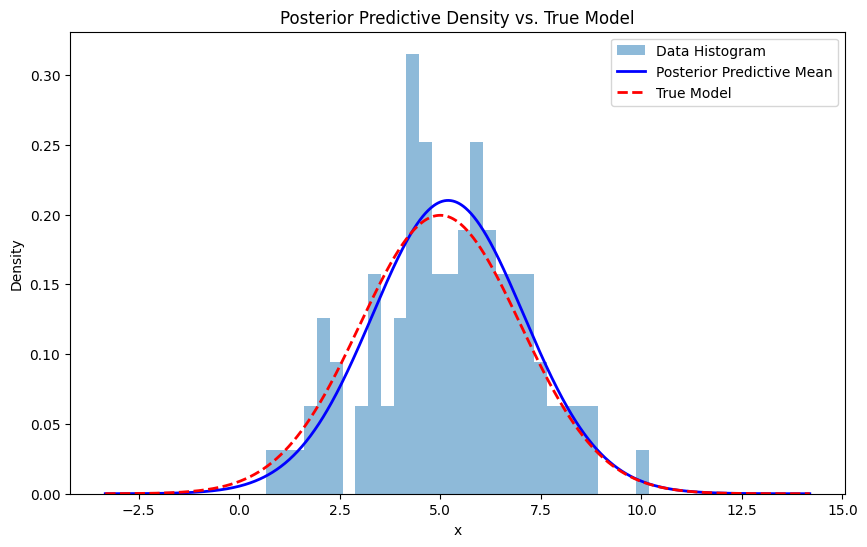

In [ ]:
# ----------------------------
# 7. Plot the Data, Posterior Predictive, and True Model
# ----------------------------
plt.figure(figsize=(10, 6))

# Histogram of the observed data (density normalized)
plt.hist(data, bins=30, density=True, alpha=0.5, label="Data Histogram")

# Plot the posterior predictive density (from the MCMC samples)
plt.plot(x_plot, posterior_predictive, color="blue", lw=2, label="Posterior Predictive Mean")

# Interpolate gaussian
# x_arr = np.linspace(min(x_plot), max(x_plot), len(data))
# interp_func = interp1d(x_arr, data, kind='cubic')
# interpolagted_data = interp_func(x_plot)

# Plot the true model density
#plt.plot(x_plot, interpolagted_data, color="red", lw=2, linestyle="--", label="True Model")
plt.plot(x_plot, true_pdf, color="red", lw=2, linestyle="--", label="True Model")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Posterior Predictive Density vs. True Model")
plt.legend()
plt.show()

MCMC decompsing

In [ ]:
# Define a single Gaussian function
def gaussian(x, amp, cen, sigma):
    """Return a Gaussian function."""
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

# Define the model: a sum of Gaussians.
def model(x, params):
    """
    Model is a sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, sigma] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        sigma = params[3 * i + 2]
        total += gaussian(x, amp, cen, sigma)
    return total

# Define the log prior
def log_prior(params):
    """
    Define flat priors for the parameters.
    Here we assume:
      - amplitudes (amp) are positive (e.g., 0 < amp < 1e5),
      - centers (cen) are within a reasonable range (e.g., 0 < cen < 1000),
      - sigmas are positive (e.g., 0 < sigma < 100).
    Adjust these limits as needed for your data.
    """
    n_gauss = len(params) // 3
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        sigma = params[3 * i + 2]
        if not (0 < amp < 1e5):
            return -np.inf
        if not (0 < cen < 1000):
            return -np.inf
        if not (0 < sigma < 100):
            return -np.inf
    return 0.0  # log(1)

# Define the log likelihood
def log_likelihood(params, x, y, yerr):
    """
    Gaussian log likelihood.

    Parameters:
        params: the parameters for the model.
        x: independent variable.
        y: data.
        yerr: uncertainties on the data.
    """
    model_y = model(x, params)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2)

# Define the full log probability function
def log_probability(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)


# -------------------------
# 1. Create synthetic data
# -------------------------
np.random.seed(42)
x = np.linspace(0, 100, 300)  # e.g., wavelength range

# True parameters for two Gaussian lines:
# Gaussian 1: amplitude=50, center=30, sigma=5.
# Gaussian 2: amplitude=30, center=70, sigma=3.
true_params = [50, 30, 5, 30, 70, 3]
y_true = model(x, true_params)

# Add Gaussian noise
noise_sigma = 2.0
y_noise = np.random.normal(0, noise_sigma, size=x.size)
y = y_true + y_noise
yerr = np.full_like(x, noise_sigma)  # constant errors

# -------------------------
# 2. Set up MCMC sampler
# -------------------------
# We'll fit for two Gaussians, so there are 6 parameters.
n_dim = 6
n_walkers = 32

# Initial guess: slight offset from true values.
initial_guess = [45, 28, 4, 28, 68, 2.5]
# Initialize walkers in a tiny ball around the initial guess.
pos = initial_guess + 1e-4 * np.random.randn(n_walkers, n_dim)

# Set up the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(x, y, yerr))

print("Running MCMC...")
n_steps = 5000
sampler.run_mcmc(pos, n_steps, progress=True)

# Remove burn-in (e.g., first 1000 steps) and flatten the chain.
burnin = 1000
samples = sampler.get_chain(discard=burnin, flat=True)
print("MCMC complete.")

# -------------------------
# 3. Analyze the samples
# -------------------------
# Compute the median of the samples for each parameter.
medians = np.median(samples, axis=0)
print("Median parameter values:")
labels = ["amp1", "cen1", "sigma1", "amp2", "cen2", "sigma2"]
for label, median in zip(labels, medians):
    print(f"  {label} = {median:.3f}")

Running MCMC...


100%|██████████| 5000/5000 [00:13<00:00, 380.24it/s]


MCMC complete.
Median parameter values:
  amp1 = 49.633
  cen1 = 29.988
  sigma1 = 5.044
  amp2 = 31.631
  cen2 = 70.003
  sigma2 = 2.866


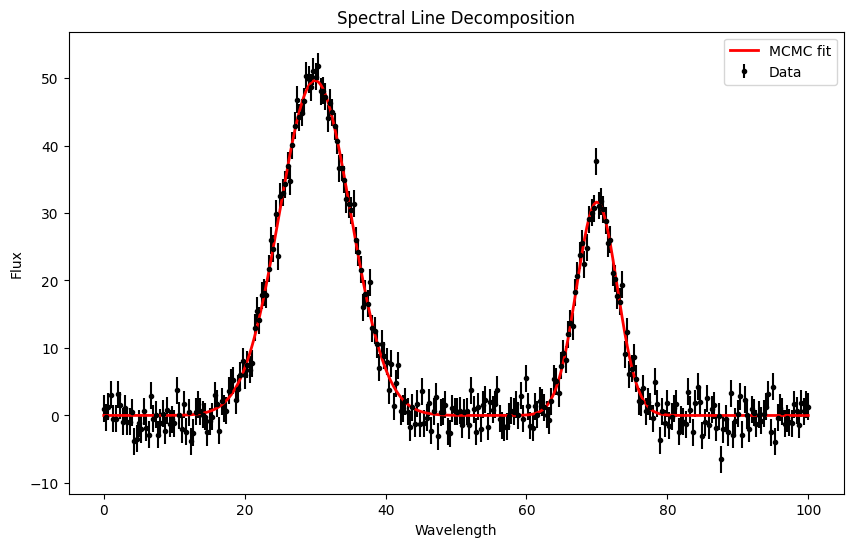

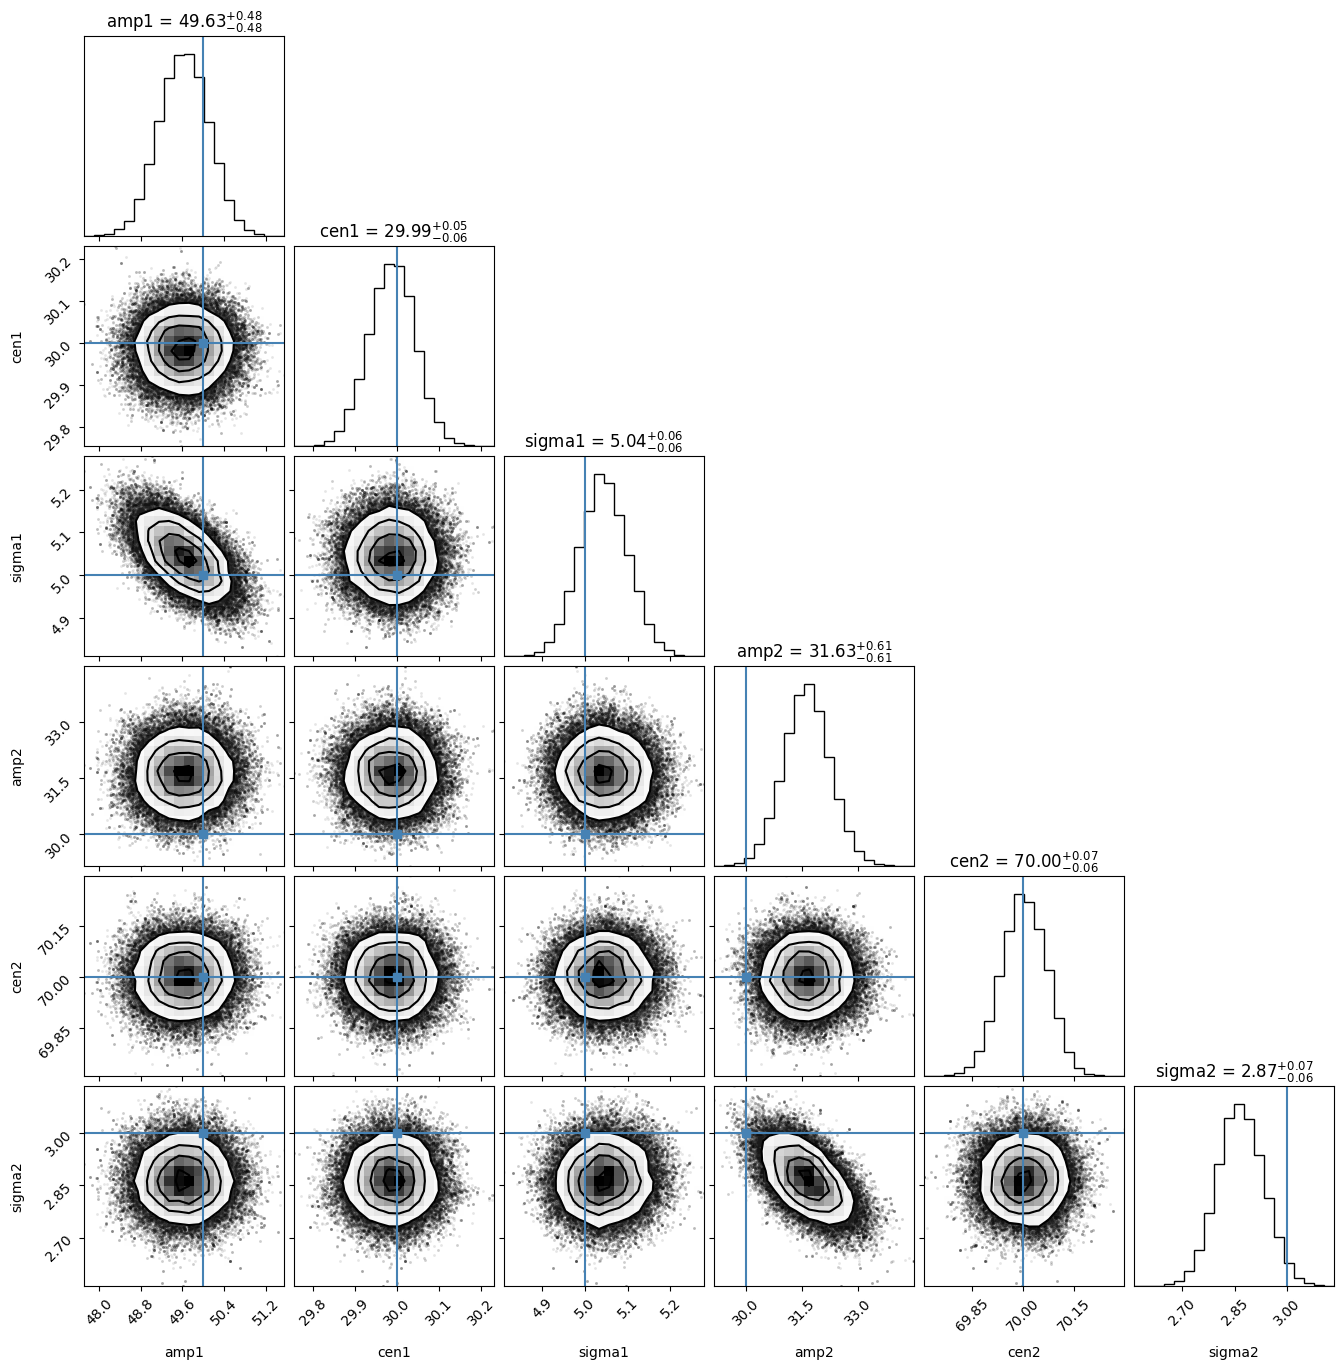

In [ ]:
# -------------------------
# 4. Plot the results
# -------------------------
# Plot the data and the best-fit model.
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt=".k", label="Data")
plt.plot(x, model(x, medians), "r", lw=2, label="MCMC fit")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend()
plt.title("Spectral Line Decomposition")
plt.show()

# Create a corner plot of the parameter distributions.
fig = corner.corner(samples, labels=labels,
                    truths=true_params,
                    show_titles=True, title_fmt=".2f",
                    title_kwargs={"fontsize": 12})
plt.show()

## Finding Peaks

In [ ]:
!pip install emcee
!pip install emcee corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.0 MB/s eta 0:00:00


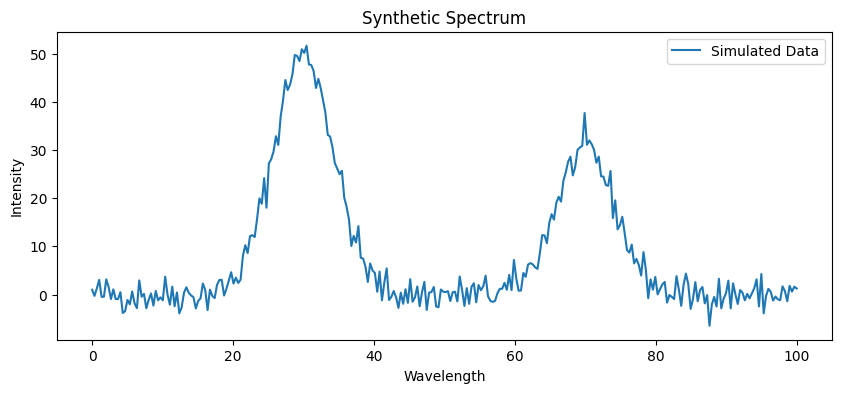

Detected peak indices: [ 65  68  71  73  78  82  86  89  91  96 106 111 113 118 125 179 186 191
 195 198 203 209 211 215 220 222 225 229 231 234]
Detected peak heights: [10.24827826 12.3282136  19.97694829 24.18076276 32.88505096 44.5565766
 49.75209014 50.95059925 51.67587626 44.80059536 25.7036534  12.18785543
 14.20873108  6.45535874  5.42897005  7.17965842  6.51582336 12.32968582
 16.68013833 20.30530836 28.63261699 37.69708937 32.00340964 28.64199166
 25.66196413 19.56326742 16.14413216 10.36106116  7.39588211  8.8093671 ]


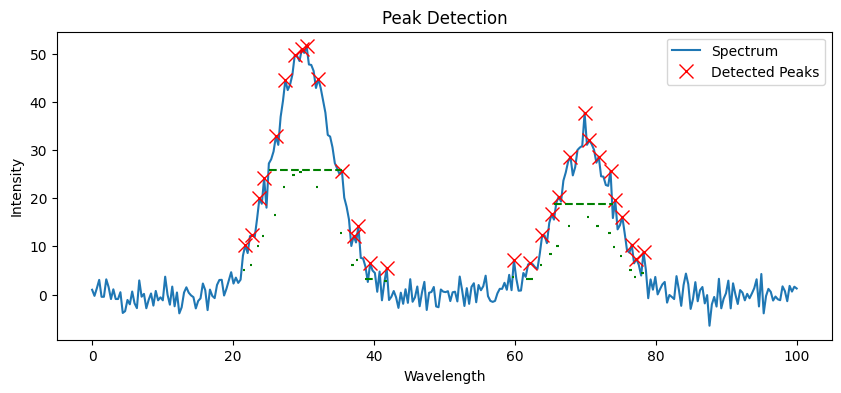

Running MCMC for 1 Gaussian(s)...


100%|██████████| 5000/5000 [00:10<00:00, 463.50it/s]


MCMC complete.
MCMC with 1 Gaussian(s): BIC = 1308.01, RSS = 22176.46
Running MCMC for 2 Gaussian(s)...


100%|██████████| 5000/5000 [00:13<00:00, 365.46it/s]


MCMC complete.
MCMC with 2 Gaussian(s): BIC = 434.33, RSS = 1138.51
Running MCMC for 3 Gaussian(s)...


100%|██████████| 5000/5000 [00:12<00:00, 406.37it/s]


MCMC complete.
MCMC with 3 Gaussian(s): BIC = 941.33, RSS = 5828.09
Running MCMC for 4 Gaussian(s)...


100%|██████████| 5000/5000 [00:15<00:00, 329.48it/s]


MCMC complete.
MCMC with 4 Gaussian(s): BIC = 1349.98, RSS = 21494.52
Running MCMC for 5 Gaussian(s)...


100%|██████████| 5000/5000 [00:15<00:00, 332.98it/s]


MCMC complete.
MCMC with 5 Gaussian(s): BIC = 1377.46, RSS = 22250.29

Optimal number of Gaussians (lowest BIC): 2


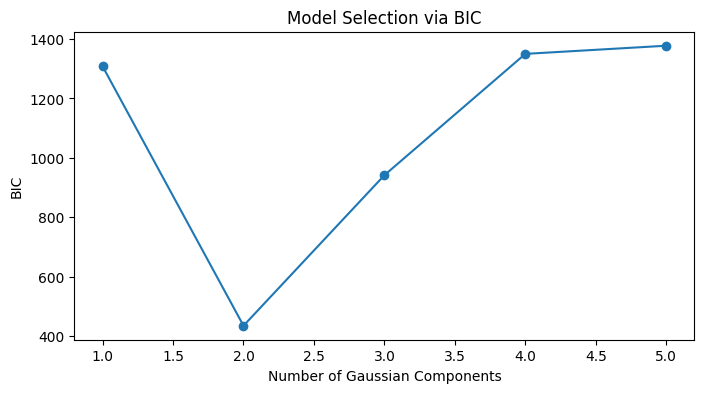

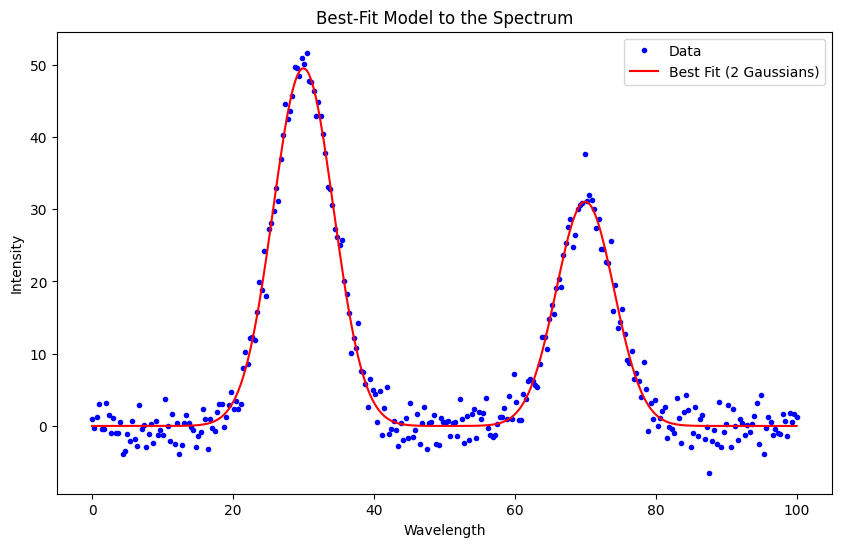


Best-fit parameters:
  Gaussian 1: amplitude = 49.54, center = 29.99, FWHM = 10.09
  Gaussian 2: amplitude = 31.07, center = 69.98, FWHM = 9.66


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.signal import find_peaks, peak_widths

# -------------------------------
# 1. Define the Model Functions
# -------------------------------
def gaussian(x, amp, cen, fwhm):
    """A single Gaussian function, using FWHM instead of standard deviation."""
    sigma = fwhm / 2.355  # Convert FWHM to sigma
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

def sum_of_gaussians(x, *params):
    """
    Sum of m Gaussians.
    Parameters: params = [amp1, cen1, fwhm1, amp2, cen2, fwhm2, ...]
    """
    m = len(params) // 3
    total = np.zeros_like(x)
    for i in range(m):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total

# -------------------------
# 2. Define Prior and Likelihood Functions
# -------------------------
def log_prior(params, bounds):
    """
    Define flat priors for the parameters.
    We assume:
      - amplitudes (amp) are positive (0 < amp < 1e5),
      - centers (cen) are within a reasonable range (e.g., 0 < cen < 1000),
      - FWHM are positive (0 < fwhm < 100).
    """
    n_gauss = len(params) // 3
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]

        lower_bound = bounds[0][3*i:3*i+3]
        upper_bound = bounds[1][3*i:3*i+3]

        if not (lower_bound[0] < amp < upper_bound[0]):
            return -np.inf
        if not (lower_bound[1] < cen < upper_bound[1]):
            return -np.inf
        if not (lower_bound[2] < fwhm < upper_bound[2]):
            return -np.inf

    return 0.0  # log(1)

def log_likelihood(params, x, y, yerr):
    """
    Gaussian log likelihood.
    """
    model_y = sum_of_gaussians(x, *params)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2)

def log_probability(params, x, y, yerr, bounds):
    lp = log_prior(params, bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

# ---------------------------------------
# 3. Simulate Synthetic Spectral Data
# ---------------------------------------
np.random.seed(42)
x = np.linspace(0, 100, 300)  # e.g., wavelength range

# True parameters for two Gaussian peaks:
true_params = [50, 30, 10, 30, 70, 10]

# Generate the true model and add noise
y_true = sum_of_gaussians(x, *true_params)
noise_sigma = 2.0  # standard deviation of the noise
noise = np.random.normal(0, noise_sigma, size=x.size)
y = y_true + noise
yerr = np.full_like(x, noise_sigma)

# Plot the simulated spectrum
plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Simulated Data")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.legend()
plt.title("Synthetic Spectrum")
plt.show()

# ---------------------------------------------------
# 4. Detect Peaks and Estimate Their Parameters
# ---------------------------------------------------
peaks, properties = find_peaks(y, height=5)
print("Detected peak indices:", peaks)
print("Detected peak heights:", properties["peak_heights"])

# Estimate widths at half maximum (FWHM) directly
results_half = peak_widths(y, peaks, rel_height=0.5)
dx = x[1] - x[0]  # spacing in x
widths = results_half[0] * dx  # these widths are already FWHM

plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Spectrum")
plt.plot(x[peaks], y[peaks], "x", label="Detected Peaks", markersize=10, color="red")
for peak, width in zip(peaks, widths):
    left = x[int(max(0, peak - width/(2*dx)))]
    right = x[int(min(len(x)-1, peak + width/(2*dx)))]
    plt.hlines(y[peak] * 0.5, left, right, color="green", linestyle="--")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.legend()
plt.title("Peak Detection")
plt.show()

# ---------------------------------------------------
# 5. Define a Function to Generate Initial Guesses
# ---------------------------------------------------
def generate_initial_guess(m, peaks, widths, x, y):
    """
    Generate an initial guess for a model with m Gaussians.
    Uses the detected peaks for the first few components.
    """
    initial_params = []
    n_detected = len(peaks)

    # Sort detected peaks by amplitude (largest first)
    if n_detected > 0:
        peak_order = np.argsort(y[peaks])[::-1]
    else:
        peak_order = []

    for i in range(m):
        if i < n_detected:
            idx = peaks[peak_order[i]]
            amp_guess = y[idx]
            cen_guess = x[idx]
            # Use the width (FWHM) directly from peak_widths
            fwhm_guess = widths[peak_order[i]] if widths.size > 0 else 3.0
        else:
            amp_guess = np.median(y)
            cen_guess = x[0] + (i+1) * (x[-1] - x[0]) / (m + 1)
            fwhm_guess = 3.0  # default guess for FWHM
        initial_params.extend([amp_guess, cen_guess, fwhm_guess])
    return initial_params

# ---------------------------------------------------
# 6. Run MCMC
# ---------------------------------------------------
def run_mcmc(x, y, yerr, m, peaks, widths, n_walkers=32, n_steps=5000):
    initial_guess = generate_initial_guess(m, peaks, widths, x, y)
    n_dim = len(initial_guess)

    # Set bounds: note that the FWHM upper bound has been increased to 50 to accommodate realistic values.
    bounds = (
        [0, x[0], 0] * m,  # lower bound: amp>0, center >= x[0], FWHM>0
        [np.max(y) * 1.5, x[-1], 50] * m  # upper bound
    )

    pos = initial_guess + 1e-4 * np.random.randn(n_walkers, n_dim)
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(x, y, yerr, bounds))

    print(f"Running MCMC for {m} Gaussian(s)...")
    sampler.run_mcmc(pos, n_steps, progress=True)

    burnin = 1000
    samples = sampler.get_chain(discard=burnin, flat=True)
    print("MCMC complete.")

    return samples, bounds

# ---------------------------------------------------
# 7. Analyze Results and Compute BIC
# ---------------------------------------------------
def compute_BIC(n, rss, k):
    return n * np.log(rss / n) + k * np.log(n)

def analyze_mcmc_results(x, y, yerr, samples, bounds):
    medians = np.median(samples, axis=0)
    model_y = sum_of_gaussians(x, *medians)
    residuals = y - model_y
    rss = np.sum(residuals**2)
    n = len(x)
    k = len(medians)
    bic = compute_BIC(n, rss, k)
    return medians, model_y, rss, bic

# ---------------------------------------------------
# 8. Run for different number of components
# ---------------------------------------------------
max_components = 5
min_components = 1
bic_values = []
fit_results = {}

for m in range(min_components, max_components + 1):
    samples, bounds = run_mcmc(x, y, yerr, m, peaks, widths)
    medians, model_y, rss, bic = analyze_mcmc_results(x, y, yerr, samples, bounds)
    fit_results[m] = (medians, model_y, rss, bic, samples)
    bic_values.append(bic)
    print(f"MCMC with {m} Gaussian(s): BIC = {bic:.2f}, RSS = {rss:.2f}")

bic_array = np.array(bic_values)
optimal_m = np.argmin(bic_array) + 1
print(f"\nOptimal number of Gaussians (lowest BIC): {optimal_m}")

plt.figure(figsize=(8, 4))
plt.plot(range(min_components, max_components + 1), bic_values, marker="o")
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.title("Model Selection via BIC")
plt.show()

# ---------------------------------------------------
# 9. Plot the Best Fit Against the Data
# ---------------------------------------------------
if fit_results[optimal_m] is not None:
    medians_opt, model_y_opt, rss_opt, bic_opt, samples_opt = fit_results[optimal_m]
    labels = [(f"amp{i+1}", f"cen{i+1}", f"FWHM{i+1}") for i in range(optimal_m)]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, "b.", label="Data")
    plt.plot(x, model_y_opt, "r-", label=f"Best Fit ({optimal_m} Gaussians)")
    plt.xlabel("Wavelength")
    plt.ylabel("Intensity")
    plt.legend()
    plt.title("Best-Fit Model to the Spectrum")
    plt.show()

    # Optionally, uncomment to create a corner plot:
    # fig = corner.corner(samples_opt, labels=labels,
    #                     truths=true_params[:len(labels)],
    #                     show_titles=True, title_fmt=".2f",
    #                     title_kwargs={"fontsize": 12})
    # plt.show()

    print("\nBest-fit parameters:")
    for i in range(optimal_m):
        amp, cen, fwhm = medians_opt[3*i:3*i+3]
        print(f"  Gaussian {i+1}: amplitude = {amp:.2f}, center = {cen:.2f}, FWHM = {fwhm:.2f}")
else:
    print("No successful fit found for the optimal model.")
